<a href="https://colab.research.google.com/github/DHjeelm/OpenProjectAboutGANs/blob/main/Vanilla_GAN_1D_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
# Imports
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import rand
from numpy.random import randn
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [119]:
# 1D function
def function(x):
  return x*x

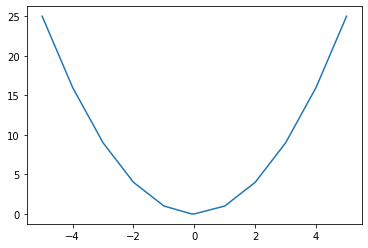

In [120]:
# Check that it works fine

input = [-5, -4, -3, -2, -1, -0.1, 0, 1, 2, 3, 4, 5]
# calculate outputs
output = [function(i) for i in input]
# plot the result
plt.plot(input, output)
plt.show()

In [121]:
# Generate samples
def generateRealSamples(numSamples =100):

  # Generate random number between -5 and 5
  input = rand(numSamples)*10 - 5

  # Calculate quadratic
  output = input * input

  # Stack arrays
  input = input.reshape(numSamples, 1)
  output = output.reshape(numSamples, 1)

  # Output
  out = hstack((input, output))

  # Label
  real = np.ones((numSamples, 1))

  return out, real

def generateFakeSamples(numSamples =100):

  # Generate random number between -5 and 5
  input = -10 + rand(numSamples)*20
  output = -10 + rand(numSamples)*20

  # Stack arrays
  input = input.reshape(numSamples, 1)
  output = output.reshape(numSamples, 1)

  # Output
  out = hstack((input, output))

  # Label
  fake = np.zeros((numSamples, 1))

  return out, fake

In [122]:
# Create the Discriminator
def Discriminator(numInputs=2):
  model = Sequential()
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform',
  input_dim=numInputs))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 25)                75        
                                                                 
 dense_25 (Dense)            (None, 1)                 26        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


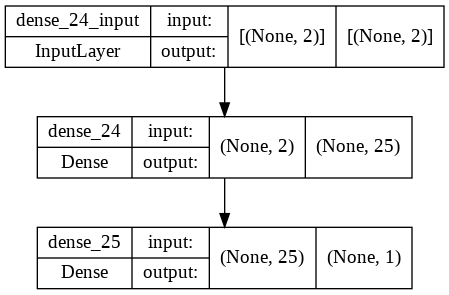

In [123]:
discriminator = Discriminator()
discriminator.summary()
plot_model(discriminator, show_shapes=True, show_layer_names=True)

In [124]:
# Pre-train discriminator
def trainDiscriminator(model, numEpochs=1000, numBatch=128):
  half_batch = int(numBatch / 2)
  # run epochs manually
  for i in range(numEpochs):
    # Generate real data
    X_real, y_real = generateRealSamples(half_batch)
    # Update model
    model.train_on_batch(X_real, y_real)
    # Generate fake data
    X_fake, y_fake = generateFakeSamples(half_batch)
    # Update model
    model.train_on_batch(X_fake, y_fake)
    # Evaluate the model
    _, acc_real = model.evaluate(X_real, y_real, verbose=0)
    _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
  print(i, acc_real, acc_fake)

# Fit the model
trainDiscriminator(discriminator)

999 1.0 0.859375


In [125]:
# Create generator
def Generator(latentDim, numOutputs=2):
  model = Sequential()
  model.add(Dense(15, activation='relu', kernel_initializer='he_uniform',
  input_dim=latentDim))
  model.add(Dense(numOutputs, activation='linear'))
  return model

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 15)                90        
                                                                 
 dense_27 (Dense)            (None, 2)                 32        
                                                                 
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


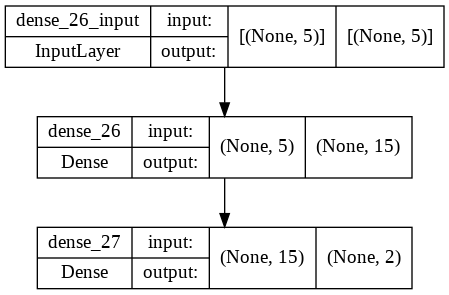

In [126]:
generator = Generator(5)
generator.summary()
plot_model(generator, show_shapes=True, show_layer_names=True)

In [127]:
# Generate input data
def generateLatentPoints(latentDim, n):
  # generate points in the latent space
  x_input = randn(latentDim * n)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n, latentDim)
  return x_input

In [128]:
# Generate fake data using generator:
def generatorGenerateFakeData(generator, latentDim, n):
  # Generate points in latent space
  x_input = generateLatentPoints(latentDim, n)
  # Predict outputs
  out = generator.predict(x_input)
  # label
  fake = np.zeros((n, 1))

  return out, fake
  

In [129]:
# Create GAN
def GAN(generator, discriminator):
  # Make weights in the discriminator not trainable
  discriminator.trainable = False
  # Connect in a Sequential()
  model = Sequential()
  # Add generator
  model.add(generator)
  # Add discriminator
  model.add(discriminator)
  # Compile
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 2)                 122       
                                                                 
 sequential_15 (Sequential)  (None, 1)                 101       
                                                                 
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


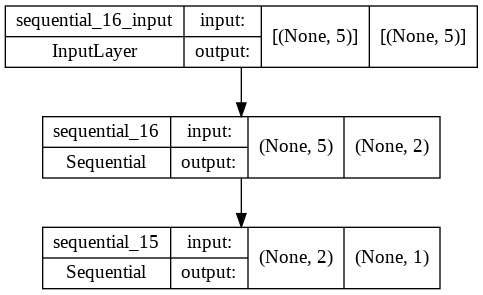

In [130]:
gan = GAN(generator, discriminator)
gan.summary()
# plot gan model
plot_model(gan, show_shapes=True, show_layer_names=True)

In [131]:
def performance(epoch, generator, discriminator, latent_dim, n=100):
  # Prepare real samples
  x_real, y_real = generateRealSamples(n)
  # Evaluate discriminator on real examples
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
  # Prepare fake examples
  x_fake, y_fake = generatorGenerateFakeData(generator, latent_dim, n)
  # Evaluate discriminator on fake examples
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  # Summarize discriminator performance
  print(epoch, acc_real, acc_fake)
  # Scatter plot real and fake data points
  plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
  plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')

In [132]:
# Training the GAN
def train(g_model, d_model, gan_model, latentDim, n_epochs=10000, n_batch=128,
  n_eval=2000):
  # determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)
  # Manually enumerate epochs
  for i in range(n_epochs):
    # Prepare real samples
    x_real, y_real = generateRealSamples(half_batch)
    # Prepare fake examples
    x_fake, y_fake = generatorGenerateFakeData(g_model, latentDim, half_batch)
    # Update discriminator
    d_model.train_on_batch(x_real, y_real)
    d_model.train_on_batch(x_fake, y_fake)
    # Prepare points in latent space as input for the generator
    x_gan = generateLatentPoints(latentDim, n_batch)
    # Create inverted labels for the fake samples
    y_gan = np.ones((n_batch, 1))
    # Update the generator via the discriminator✬s error
    gan_model.train_on_batch(x_gan, y_gan)
    # Evaluate the model every n_eval epochs
    if (i+1) % n_eval == 0:
      performance(i, g_model, d_model, latentDim)

1999 0.550000011920929 0.7400000095367432
3999 0.33000001311302185 0.7599999904632568
5999 0.6299999952316284 0.3700000047683716
7999 0.550000011920929 0.5299999713897705
9999 0.699999988079071 0.2800000011920929


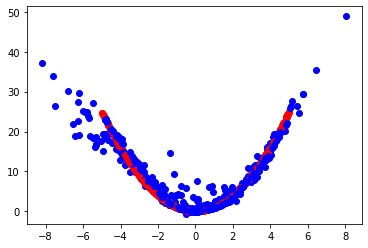

In [133]:
latentDim = 5
discriminator = Discriminator()
generator = Generator(latentDim)
gan = GAN(generator, discriminator)
train(generator, discriminator, gan, latentDim)